## 1/ Importation des bibliothèques

In [1]:
import sys
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pprint import pprint
from facebook_scraper import get_posts, fetch_share_and_reactions 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore
from gensim.models import CoherenceModel
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

## 2/ Collecte des données

In [2]:
fb_data = []
for post in get_posts('mcdonaldsfrance', pages=100):
    fb_data.append(fetch_share_and_reactions(post))

In [3]:
len(fb_data)

400

In [18]:
print(fb_data[5].keys())

dict_keys(['post_id', 'text', 'post_text', 'shared_text', 'time', 'image', 'likes', 'comments', 'shares', 'post_url', 'link', 'reactions', 'w3_fb_url', 'fetched_time'])


In [29]:
def extract_comment_attributes(post_object):
    post_list =[]
    for post in post_object:
        post_id = post['post_id']
        text = post['text']
        shared_text = post['shared_text']
        time = post['time']
        reactions = post['likes']
        comments = post['comments']
        shares = post['shares']
        like_reaction = 0 if 'reactions' not in post.keys() or 'like' not in post['reactions'].keys() else post['reactions']['like']
        haha_reaction = 0 if 'reactions' not in post.keys() or 'haha' not in post['reactions'].keys() else post['reactions']['haha']
        love_reaction = 0 if 'reactions' not in post.keys() or 'love' not in post['reactions'].keys() else post['reactions']['love']
        anger_reaction = 0 if 'reactions' not in post.keys() or 'anger' not in post['reactions'].keys() else post['reactions']['anger']
        wow_reaction = 0 if 'reactions' not in post.keys() or 'wow' not in post['reactions'].keys() else post['reactions']['wow']
        sorry_reaction = 0 if 'reactions' not in post.keys() or 'sorry' not in post['reactions'].keys() else post['reactions']['sorry']
        # append attributes to list
        post_list.append({'post_id':post_id, 
                          'text':text, 
                          'shared_text':shared_text,
                          'time':time, 
                          'reactions':reactions, 
                          'comments':comments, 
                          'shares':shares,
                          'like_reaction':like_reaction,
                          'haha_reaction': haha_reaction,
                          'love_reaction': love_reaction,
                          'anger_reaction': anger_reaction,
                          'wow_reaction': wow_reaction,
                          'sorry_reaction': sorry_reaction})
    
    df = pd.DataFrame(post_list, columns=['post_id',
                                           'text',
                                           'shared_text',
                                           'time',
                                           'reactions',
                                           'comments',
                                           'shares',
                                           'like_reaction',
                                           'haha_reaction',
                                           'love_reaction',
                                           'anger_reaction',
                                           'wow_reaction',
                                           'sorry_reaction'])
    return df


df = extract_comment_attributes(fb_data)

In [30]:
df.head()

,post_id,text,shared_text,time,reactions,comments,shares,like_reaction,haha_reaction,love_reaction,anger_reaction,wow_reaction,sorry_reaction
0,2849712391750985,Pour divertir les plus petits pendant ces long...,,2020-04-16 17:02:56,212,110,93,187,0,25,0,0,0
1,2827050184017206,Pour divertir vos enfants et partager un bon m...,,2020-04-06 17:23:46,1484,668,914,1284,20,119,54,5,2
2,2750328441689381,C’est LE trio dont tout le monde va parler !\n...,,2020-03-10 11:58:22,4556,6795,442,3569,41,748,27,157,14
3,2755255451196680,Question de la plus haute importance :\n➡️ tu ...,,2020-03-08 17:57:07,452,1003,15,428,12,12,0,0,0
4,2705846959470863,🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚...,,2020-03-06 11:57:06,1615,1398,70,1393,141,50,14,15,2


In [31]:
df.to_csv('fbposts.csv', index = False, header=True)

## 3/ Prétraitement des données

### 3-1/ Tokenization

In [32]:
df = pd.read_csv("fbposts.csv")
df["tokens"] = df["text"].astype('str')

In [33]:
df["tokens"] = df["tokens"].apply(word_tokenize)

In [34]:
df.tokens

0      [Pour, divertir, les, plus, petits, pendant, c...
1      [Pour, divertir, vos, enfants, et, partager, u...
2      [C, ’, est, LE, trio, dont, tout, le, monde, v...
3      [Question, de, la, plus, haute, importance, :,...
4      [🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚🥚...
                             ...                        
395    [L'affrontement, suprême, :, Royal, Cheese, ou...
396    [Alors, alors, qu'avez-vous, reçu, de, beau, à...
397    [On, vous, souhaite, à, tous, de, très, belles...
398    [❄️, C'est, l'hiver, ,, vite, vite, on, se, ré...
399    [Pour, motiver, ta, meilleure, pote, à, ramene...
Name: tokens, Length: 400, dtype: object

In [35]:
all_training_words = [word for tokens in df["tokens"] for word in tokens]
len(all_training_words)

7612

### 3-2/ Nettoyage des données

In [36]:
df["tokens"] = df["tokens"].apply(lambda tokens : [word.lower() for word in tokens if word.isalpha()])

In [37]:
df.tokens

0      [pour, divertir, les, plus, petits, pendant, c...
1      [pour, divertir, vos, enfants, et, partager, u...
2      [c, est, le, trio, dont, tout, le, monde, va, ...
3      [question, de, la, plus, haute, importance, tu...
4                                                     []
                             ...                        
395               [suprême, royal, cheese, ou, big, mac]
396    [alors, alors, reçu, de, beau, à, noël, onveut...
397    [on, vous, souhaite, à, tous, de, très, belles...
398          [vite, vite, on, se, réchauffe, les, mains]
399    [pour, motiver, ta, meilleure, pote, à, ramene...
Name: tokens, Length: 400, dtype: object

### 3-3/ Stopwords

In [38]:
stop_words = set(stopwords.words(['french','english']))
df["tokens"] = df["tokens"].apply(lambda tokens : [word for word in tokens if not word in stop_words])

In [39]:
df.tokens

0      [divertir, plus, petits, pendant, longues, jou...
1      [divertir, enfants, partager, bon, moment, mai...
2      [trio, dont, tout, monde, va, parler, part, qu...
3      [question, plus, haute, importance, manges, ab...
4                                                     []
                             ...                        
395                   [suprême, royal, cheese, big, mac]
396    [alors, alors, reçu, beau, noël, onveuttoutsav...
397          [souhaite, tous, très, belles, fêtes, noël]
398                       [vite, vite, réchauffe, mains]
399    [motiver, meilleure, pote, ramener, mcdo, moti...
Name: tokens, Length: 400, dtype: object

### 3-4/ Lemmatisation et Stemming

In [40]:
#wordnet = WordNetLemmatizer()
#df["tokens"] = df["tokens"].apply(lambda tokens : [wordnet.lemmatize(word) for word in tokens])

In [41]:
snowball = SnowballStemmer(language="french")
df["tokens"] = df["tokens"].apply(lambda tokens : [snowball.stem(word) for word in tokens])

In [42]:
df.tokens

0      [divert, plus, petit, pend, longu, journ, mais...
1      [divert, enfant, partag, bon, moment, maison, ...
2      [trio, dont, tout, mond, va, parl, part, quel,...
3      [question, plus, haut, import, mang, abord, fr...
4                                                     []
                             ...                        
395                     [suprêm, royal, chees, big, mac]
396     [alor, alor, reçu, beau, noël, onveuttoutsavoir]
397                [souhait, tous, tres, bel, fêt, noël]
398                           [vit, vit, réchauff, main]
399    [motiv, meilleur, pot, ramen, mcdo, motiv, mcd...
Name: tokens, Length: 400, dtype: object

In [43]:
all_training_words = [word for tokens in df["tokens"] for word in tokens]
len(all_training_words)

3064

### 4/ Enregistrer les changements

In [44]:
df.to_csv('fbposts.csv', index = False, header=True)

## 5/ BoW (Bag of Words)

In [54]:
processed_docs = df.tokens

In [55]:
dct = Dictionary(processed_docs)
dct.filter_extremes(no_below=15, keep_n=100000)
print(dct)

Dictionary(31 unique tokens: ['bon', 'cet', 'happy', 'moment', 'tout']...)


## 6/ bow_corpus

In [56]:
processed_docs = processed_docs.iloc[:-10]
# Les 10 dernières lignes sont réservées pour le test

In [57]:
bow_corpus = [dct.doc2bow(doc) for doc in processed_docs]
bow_corpus[0:3]

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1)], [(6, 1)]]

## 7/ Modèle TF-IDF

In [58]:
model_tfidf = TfidfModel(bow_corpus,normalize=True)

In [59]:
corpus_tfidf = model_tfidf[bow_corpus]
corpus_tfidf[0]

[(0, 0.5396898713164865),
 (1, 0.4537319385194441),
 (2, 0.45999675386265065),
 (3, 0.5396898713164865)]

## 8/ Modèle LDA

In [60]:
model_lda = LdaMulticore(bow_corpus,num_topics=10, id2word=dct, chunksize=100, iterations=25, passes=2, workers=3)

In [61]:
pprint(model_lda.top_topics(bow_corpus)[0:2])

[([(0.25049713, 'cet'),
   (0.21108739, 'va'),
   (0.16357334, 'fair'),
   (0.10295469, 'si'),
   (0.04447551, 'ça'),
   (0.039179105, 'tous'),
   (0.038182914, 'happy'),
   (0.034803852, 'meal'),
   (0.02601457, 'jusqu'),
   (0.019731946, 'chez'),
   (0.016081993, 'meilleur'),
   (0.014187828, 'bien'),
   (0.0020682553, 'restaur'),
   (0.002067755, 'tout'),
   (0.0020675506, 'mcdonald'),
   (0.002066043, 'fait'),
   (0.0020653873, 'mcdo'),
   (0.0020651894, 'retour'),
   (0.0020650458, 'plus'),
   (0.0020649168, 'post')],
  -9.21834689729355),
 ([(0.21791425, 'fait'),
   (0.15752909, 'tout'),
   (0.13651593, 'bien'),
   (0.08408232, 'restaur'),
   (0.052557953, 'retour'),
   (0.048626736, 'cet'),
   (0.047459718, 'jusqu'),
   (0.047037505, 'ça'),
   (0.02470307, 'meilleur'),
   (0.022118965, 'plus'),
   (0.019115137, 'happy'),
   (0.018886255, 'mcdonald'),
   (0.016080972, 'va'),
   (0.015370932, 'gagn'),
   (0.015323534, 'fair'),
   (0.012814875, 'grand'),
   (0.008310074, 'big'),
  

In [62]:
for idx,topic in model_lda.print_topics():
    pprint('Topic {} : Word: {}'.format(idx,topic))

('Topic 0 : Word: 0.142*"moment" + 0.138*"famill" + 0.134*"restaur" + '
 '0.085*"retour" + 0.061*"chez" + 0.060*"mcdonald" + 0.055*"bon" + '
 '0.044*"grand" + 0.039*"tous" + 0.036*"tout"')
('Topic 1 : Word: 0.127*"mcdonald" + 0.107*"monopoly" + 0.106*"gagn" + '
 '0.089*"octobr" + 0.080*"big" + 0.080*"tirag" + 0.079*"sort" + 0.055*"chez" + '
 '0.037*"ça" + 0.029*"tous"')
('Topic 2 : Word: 0.194*"mcdo" + 0.179*"bon" + 0.113*"post" + 0.084*"si" + '
 '0.062*"tous" + 0.041*"gagn" + 0.037*"chez" + 0.035*"mcdonald" + 0.030*"meal" '
 '+ 0.030*"happy"')
('Topic 3 : Word: 0.250*"cet" + 0.211*"va" + 0.164*"fair" + 0.103*"si" + '
 '0.044*"ça" + 0.039*"tous" + 0.038*"happy" + 0.035*"meal" + 0.026*"jusqu" + '
 '0.020*"chez"')
('Topic 4 : Word: 0.132*"gagn" + 0.112*"monopoly" + 0.112*"sort" + '
 '0.112*"mcdonald" + 0.111*"tirag" + 0.082*"novembr" + 0.049*"tous" + '
 '0.036*"mcdo" + 0.033*"moment" + 0.031*"tout"')
('Topic 5 : Word: 0.280*"tous" + 0.139*"fair" + 0.052*"restaur" + '
 '0.050*"mcdonald" +

## 9/ Modèle LDA-TFIDF

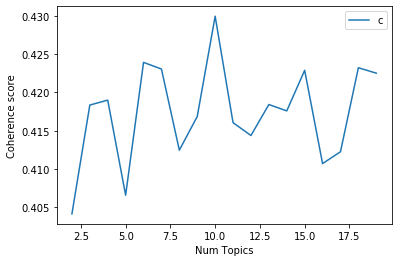

In [63]:
# Hyperparameter Tuning

topics_range = range(2, 20, 1)
model_results = { 'Topics': [],
                 'Coherence': []
                }

for k in topics_range:
    lda_model_test = LdaMulticore(corpus=corpus_tfidf, id2word=dct, num_topics=k, random_state=42, chunksize=100, iterations=25, passes=2, workers=3)
    coherence_model_lda = CoherenceModel(model=lda_model_test, texts=processed_docs, dictionary=dct, coherence='c_v')    
    cv = coherence_model_lda.get_coherence()
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

plt.plot(model_results['Topics'], model_results['Coherence'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- num_topics optimale est : 10

In [64]:
model_tfidf_lda = LdaMulticore(corpus_tfidf,num_topics=10,random_state=42, id2word=dct, chunksize=100, iterations=25, passes=2, workers=3)

In [65]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim
#pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_tfidf_lda, corpus_tfidf, dct)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.196954  0.126898       1        1  17.455956
8      0.196513 -0.035993       2        1  11.982738
7     -0.144919 -0.081831       3        1  11.185223
6      0.205530  0.040032       4        1  10.475227
9     -0.200822  0.049341       5        1   9.978467
4     -0.039596 -0.257908       6        1   9.493366
0      0.108078  0.166131       7        1   8.674527
2     -0.006859  0.072254       8        1   8.284645
3      0.071930 -0.080570       9        1   7.182561
1      0.007100  0.001647      10        1   5.287284, topic_info=       Term       Freq      Total Category  logprob  loglift
4      tout  20.000000  20.000000  Default  30.0000  30.0000
16       ça  17.000000  17.000000  Default  29.0000  29.0000
6      plus  20.000000  20.000000  Default  28.0000  28.0000
15     fait  18.000000  18.000000  Default  27.0000  27.0000
8   

In [66]:
pprint(model_tfidf_lda.top_topics(bow_corpus)[0:2])

[([(0.22535524, 'plus'),
   (0.16238347, 'retour'),
   (0.14907233, 'bien'),
   (0.08008613, 'cet'),
   (0.07133874, 'meilleur'),
   (0.0708499, 'restaur'),
   (0.06685482, 'jusqu'),
   (0.058118273, 'bon'),
   (0.017415766, 'mcdo'),
   (0.01724709, 'ça'),
   (0.014025761, 'chez'),
   (0.003368356, 'tous'),
   (0.0033655053, 'fait'),
   (0.0033646806, 'tout'),
   (0.003364215, 'mcdonald'),
   (0.003364212, 'happy'),
   (0.0033640992, 'fair'),
   (0.003362647, 'famill'),
   (0.0033622794, 'grand'),
   (0.003362275, 'va')],
  -8.400538767705239),
 ([(0.27535754, 'tous'),
   (0.17676179, 'restaur'),
   (0.11737477, 'bon'),
   (0.095411144, 'cet'),
   (0.05810507, 'bien'),
   (0.057543468, 'famill'),
   (0.05031552, 'jusqu'),
   (0.029087918, 'tout'),
   (0.017524475, 'moment'),
   (0.016616827, 'plus'),
   (0.014297566, 'happy'),
   (0.010554924, 'big'),
   (0.010047673, 'ça'),
   (0.009500105, 'post'),
   (0.00916627, 'mcdonald'),
   (0.0069166864, 'fair'),
   (0.005735542, 'grand'),
   

In [67]:
for idx,topic in model_tfidf_lda.print_topics():
    pprint('Topic {} : Word: {}'.format(idx,topic))

('Topic 0 : Word: 0.395*"tout" + 0.168*"mcdo" + 0.082*"meilleur" + '
 '0.060*"retour" + 0.043*"mcdonald" + 0.043*"bon" + 0.033*"grand" + '
 '0.028*"tous" + 0.026*"restaur" + 0.018*"fait"')
('Topic 1 : Word: 0.147*"retour" + 0.110*"mcdo" + 0.084*"chez" + '
 '0.060*"restaur" + 0.056*"moment" + 0.051*"fait" + 0.047*"fair" + '
 '0.047*"tout" + 0.044*"happy" + 0.038*"octobr"')
('Topic 2 : Word: 0.166*"grand" + 0.121*"meilleur" + 0.093*"chez" + '
 '0.072*"mcdonald" + 0.056*"mcdo" + 0.053*"retour" + 0.045*"cet" + '
 '0.041*"gagn" + 0.041*"restaur" + 0.031*"plus"')
('Topic 3 : Word: 0.226*"famill" + 0.176*"plus" + 0.128*"grand" + '
 '0.096*"moment" + 0.043*"tous" + 0.043*"fair" + 0.028*"mcdo" + 0.025*"happy" '
 '+ 0.021*"jusqu" + 0.021*"mcdonald"')
('Topic 4 : Word: 0.244*"meal" + 0.227*"happy" + 0.197*"va" + 0.065*"moment" + '
 '0.036*"jusqu" + 0.032*"bon" + 0.029*"mcdonald" + 0.021*"plus" + 0.016*"gagn" '
 '+ 0.014*"tous"')
('Topic 5 : Word: 0.140*"gagn" + 0.129*"big" + 0.119*"monopoly" + '


#### Sujets(Topics) :
- Topic 0 : Qualité
- Topic 1 : Equité
- Topic 2 : Taille
- Topic 3 : Famille
- Topic 4 : Bonheur
- Topic 5 : Cadeaux
- Topic 6 : Bonheur
- Topic 7 : Equité
- Topic 8 : Famille
- Topic 9 : Tirage

## 10/ Evaluation de la modèle LDA-TFIDF

In [68]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_tfidf_lda, texts=processed_docs, dictionary=dct, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4268938871729565


## 11/ Test

In [69]:
def format_topics_tweets(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_tweets_keywords = format_topics_tweets(ldamodel=model_tfidf_lda, corpus=corpus_tfidf, texts=df.text.iloc[-10:].tolist())

# Format
df_dominant_topic = df_topic_tweets_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Topic_Keywords,Text
0,0,4.0,0.3671,"meal, happy, va, moment, jusqu, bon, mcdonald,...",#TeamDuLendemain
1,1,4.0,0.3643,"meal, happy, va, moment, jusqu, bon, mcdonald,...",NaN
2,2,6.0,0.5500,"plus, retour, bien, cet, meilleur, restaur, ju...",Pensée pour après-demain ... Voici le kit de s...
3,3,0.0,0.1000,"tout, mcdo, meilleur, retour, mcdonald, bon, g...",Pour motiver le meilleur de la bande à ramener...
4,4,2.0,0.3728,"grand, meilleur, chez, mcdonald, mcdo, retour,...",L'affrontement suprême : Royal Cheese ou Big M...
5,5,0.0,0.1000,"tout, mcdo, meilleur, retour, mcdonald, bon, g...",Alors alors qu'avez-vous reçu de beau à Noël ?...
6,6,8.0,0.5500,"tous, restaur, bon, cet, bien, famill, jusqu, ...",On vous souhaite à tous de très belles fêtes d...
7,7,9.0,0.5500,"ça, fait, si, gagn, happy, cet, post, tout, ti...","❄️ C'est l'hiver, vite vite on se réchauffe le..."
8,8,0.0,0.5500,"tout, mcdo, meilleur, retour, mcdonald, bon, g...","Pour motiver ta meilleure pote à ramener McDo,..."
9,9,3.0,0.6264,"famill, plus, grand, moment, tous, fair, mcdo,...","Pour motiver ton meilleur pote à ramener McDo,..."


Interprétation : On peut déterminer d'après le topic modelling que les thèmes les plus communes dans les publications de page Facebook de Mcdo France sont les sujets : les cadeaux, les offres et les actualités de Mcdo  ... Donc on peut déduire que Mcdo France cherche à partager ses nouvelles aux ses clients.

Ces données nous laissent connaître l'image que Mcdo france veut garder.